# Gradient prediction

This notebook will illustrate how to calculate gradients with respect to model input.

In [1]:
# First let's select and setup the model:
import kipoi
model_name = "Basset"
#kipoi.pipeline.install_model_requirements(model_name)
# get ahold of the model
model = kipoi.get_model(model_name)

For gradient prediction we need a set of parameters like:

 - `layer`: The gradient will then be calculated in repect to the activation of that layer
 - `filter_idx`: The filter from which the activation shall be used to calculate the gradient - this is optional and if not set then all filter outputs are passed to the avg_func
 - `avg_func`: How we want to average over multiple filter outputs - take the sum, the minimum, the maximum or the maximum of the absolute values.

The `Basset` model we are using here is a multitask model that predicts probabilities of accesible genomic regions in 164 cell types. It is a multi-task model and therefore accepts one input (600bp DNA sequence) and produces 164 predictions simulatneously. 

Let's start out with selecting model parameters. Most importantly we want to select a layer by its index. For PyTorch models the layers can be displayed just by running:

In [2]:
model.model

Sequential(
  (0): Conv2d(4, 300, kernel_size=(19, 1), stride=(1, 1))
  (1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(300, 200, kernel_size=(11, 1), stride=(1, 1))
  (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(200, 200, kernel_size=(7, 1), stride=(1, 1))
  (9): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  (12): Lambda()
  (13): Sequential(
    (0): Lambda()
    (1): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (14): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()

Here we want to see which inputs were important for giving a prediction in the model output we will select the output from layer 21.1 - we don't want to calculate the gradients based on outputs of a nonlinearity.

The model is a multi-task model predicting chromatin accessibility for 164 cell types, we want to calculate the gradients with respect to exactly one of those cell types: K562. In order to select the filter which produces this value we can use the model task annotation that is stored in the Kipoi model:

In [3]:
filter_idx = model.schema.targets.column_labels.index('K562')
filter_idx

120

Now that we have decided about the model-related setup we need to produce model input data using the model dataloader. Just like for any other prediction with Kipoi we have to define the dataloader keyword arguments with which the dataloader can be executed. The `Basset` default dataloader takes two arguments: `fasta_file` and `intervals_file`. The `intervals_file` is a bed file defining regions for which input data is generated.

We want to look at a DNAse-seq peak in the K562 cell line. So we will first download a bed file of the peaks:

In [4]:
!wget -P example_data http://hgdownload.cse.ucsc.edu/goldenpath/hg19/encodeDCC/wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz

--2018-07-27 10:51:15--  http://hgdownload.cse.ucsc.edu/goldenpath/hg19/encodeDCC/wgEncodeAwgDnaseUniform/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1845863 (1.8M) [application/x-gzip]
Saving to: ‘example_data/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz.1’

100%[======================================>] 1,845,863    487KB/s   in 3.7s   

2018-07-27 10:51:19 (487 KB/s) - ‘example_data/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz.1’ saved [1845863/1845863]



Now let's randomly extract the first peak in the downloaded file in chromosome 22 into a bed file:

In [5]:
! gzip -dc example_data/wgEncodeAwgDnaseUwdukeK562UniPk.narrowPeak.gz | grep "^chr22" | head -n 1 > example_data/Basset_grad_query.bed
! cat example_data/Basset_grad_query.bed

grep: write error

gzip: stdout: Broken pipe
chr22	16197740	16197890	.	0	.	0	-1	-1	-1


There is one more thing we need to keep in mind - `Basset` only works with 600bp sequence length genomic regions, so we can centre our query region on the peak selected above:

In [6]:
model_seq_length = 600
with open("example_data/Basset_grad_query.bed", "r") as ifh:
    with open("example_data/Basset_grad_query_Basset.bed", "w") as ofh:
        for l in ifh:
            tokens = l.rstrip().split("\t")
            center = (int(tokens[1]) + int(tokens[2]))//2
            ofh.write("\t".join([tokens[0], str(center -model_seq_length//2),
                                 str(center + model_seq_length//2  + model_seq_length%2)]) + "\n")

In [7]:
! cat example_data/Basset_grad_query_Basset.bed

chr22	16197515	16198115


In [8]:
dataloader_arguments = {"fasta_file": "example_data/hg19_chr22.fa",
                        'intervals_file': "example_data/Basset_grad_query_Basset.bed"}

The `dataloader_arguments` are keyword arguments passed on to the dataloader in order to setup data generation. In the next step we run the `input_grad` pipeline to get gradients and model inputs.

In [9]:
grad_preds = model.pipeline.input_grad(dataloader_arguments, layer="21.1", filter_idx = filter_idx)

1it [00:00, 13.10it/s]


Now that the gradients are calculated we can plot the results using the `GradPlotter` class. This class has momentarily been removed from the repository hence I am posting its definition here:

In [10]:
from kipoi import readers
from kipoi_veff.utils import ModelInfoExtractor
from kipoi_veff.utils.generic import _get_metadata_name, _get_seq_shape
from kipoi_veff.utils import ReshapeDna
import kipoi
import os
import numpy as np
import logging
from kipoi.utils import cd


def grad_x_input(input, grad):
    return input * grad


def get_selector(dim, slice_at_dim):
    """
    Place `slice_at_dim` at dimension `dim` for setting or setting items
    """
    if dim >= 0:
        selector = [slice(None) for i in range(dim)] + [slice_at_dim] + [Ellipsis]
    else:
        selector = [Ellipsis] + [slice_at_dim] + [slice(None) for i in range((dim) * (-1) - 1)]
    selector = tuple(selector)
    return selector


# TODO - why is this called gradPlotter? In theory, this could be any other importance score...

# - can't depend on anything from kipoi.postprocessing..

class GradPlotter(object):
    """
    Class for plotting gradients. Results can be loaded from a HDF5 file or directly from returns of
    model.input_grad(...)
    """

    def __init__(self, data, model, source="kipoi", grad_preds=None):
        """
        Arguments:
           data: model input data batch
            model: model name as used for running `model.input_grad(...)`
            source: model source as used for running `model.input_grad(...)`
            grad_preds: return value of `model.input_grad(...)`. Can alternatively already be present in `data`
            argument under the key `preds`. In that case `grad_preds` may be None.
        """
        # TODO - prettify this init
        self.data = data
        if grad_preds is not None:
            self.data['grads'] = grad_preds
        else:
            assert 'grads' in self.data

        # TODO: R: Instead of copying from kipoi.model should we rather have a get_model_descr
        #             -- Z: this function is indeed available
        # TODO-cont: funcion that is also called from get_model
        # Taken from get_model
        source_name = source
        source = kipoi.config.get_source(source)
        md = source.get_model_descr(model)

        if ":" in md.default_dataloader:
            dl_source, dl_path = md.default_dataloader.split(":")
        else:
            dl_source = source_name
            dl_path = md.default_dataloader

        # allow to use relative and absolute paths for referring to the dataloader
        default_dataloader_path = os.path.join("/" + model, dl_path)[1:]
        # This one loads the model!!
        # default_dataloader = kipoi.get_dataloader_factory(default_dataloader_path,
        #                                                  dl_source)

        # TODO: Is there a nicer way of getting ahold of the dataloader description?
        yaml_path = source.pull_dataloader(default_dataloader_path)
        dataloader_dir = os.path.dirname(yaml_path)
        from kipoi.components import DataLoaderDescription
        with cd(dataloader_dir):
            dl = DataLoaderDescription.load(os.path.basename(yaml_path))
            default_dataloader = dl

        try:
            self.mie = ModelInfoExtractor(md, default_dataloader)
        except:
            logger.warn("Model is not enabled for variant effect prediction hence it is unclear whether there is a DNA "
                        "sequence input, so (automatic) seqlogo plots are not available for this model.")
            self.mie = None
        self.md = md
        self.dataloader = default_dataloader

        # how can the correct model input be selected
        self.get_dataset, self.model_input_keylist = self._get_ds_extractor(md.schema.inputs)

    @classmethod
    def from_hdf5(self, results_fname, model, source="kipoi"):
        """
        Arguments:
            results_fname: HDF5 file produced by running `model.input_grad(...)`. The file has to contain
            also the model input!
            model: model name as used for running `model.input_grad(...)`
            source: model source as used for running `model.input_grad(...)`
        """
        data = readers.HDF5Reader.load(results_fname, unflatten=True)
        return self(data, model=model, source=source)

    def _get_ds_extractor(self, model_input_schema):
        from kipoi.components import ArraySchema
        # return data selection function + labels
        if isinstance(model_input_schema, ArraySchema):
            return self._select_ds_ndarray, [model_input_schema.name]
        elif isinstance(model_input_schema, list):
            return self._select_ds_list, [el.name for el in model_input_schema]
        elif isinstance(model_input_schema, dict):
            return self._select_ds_dict, [el for el in model_input_schema]

    def _select_ds_ndarray(self, index, dataset):
        if index is not None:
            assert (index == 0) or (self.model_input_keylist[0] == index)
        return dataset

    def _select_ds_list(self, index, dataset):
        if isinstance(index, int):
            return dataset[index]
        else:
            int_ind = self.model_input_keylist.index(index)
            return dataset[int_ind]

    def _select_ds_dict(self, index, dataset):
        return dataset[index]

    def _verify_model_input(self, model_input):
        if model_input is None:
            if len(self.model_input_keylist) != 1:
                raise Exception("model_input cannot be None for models that have multiple "
                                "inputs: %s" % str(self.model_input_keylist))
            model_input = self.model_input_keylist[0]
        return model_input

    def get_num_samples(self, model_input=None):
        """
        Get number of samples present in the dataset (size of 0th dimension of the model input).
        Arguments:
            model_input: Number of samples will be returned for that model input.
        """
        model_input = self._verify_model_input(model_input)
        input = self.get_dataset(model_input, self.data["inputs"])
        return input.shape[0]

    @staticmethod
    def _infer_seq_dim(len, array_shape):
        sel = np.array(array_shape) == len
        if sel.sum() == 1:
            return np.where(sel)[0][0]
        return None

    def _preprocess_values(self, sample, model_input=None,
                           limit_region=None, limit_region_genomic=None,
                           transform_fn=grad_x_input,
                           seq_dim=None,
                           requires_region_info=False,
                           requires_seq_dim=False):
        def raise_missing_metadata():
            raise Exception("limit_region_genomic can only be used with a `model_input` that has an associated"
                            "metadata field with at least the following entries: 'chrom', 'start', 'end' or type"
                            "GenomicRanges.")

        def get_metadata_cse():
            metadata_field = None
            try:
                metadata_field = _get_metadata_name(self.dataloader, model_input)
            except ValueError:
                raise_missing_metadata()
            mf = self.data['metadata'][metadata_field]
            if not all([el in mf for el in ["chr", "start", "end"]]):
                raise_missing_metadata()
            cse = {k: np.squeeze(mf[k]) for k in ["chr", "start", "end"]}
            for k in ["chr", "start", "end"]:
                cse[k] = np.squeeze(mf[k])
                # if only one sample then squeeze does too much, so correct that:
                if len(cse[k].shape) == 0:
                    cse[k] = np.array([cse[k]])
                if len(cse[k].shape) != 1:
                    raise Exception("Invalid metadata format for field ['%s']['%s'] with shape: %s" %
                                    (metadata_field, k, str(mf[k].shape)))
            return cse

        inputs = self.data["inputs"]
        gradients = self.data["grads"]

        model_input = self._verify_model_input(model_input)

        input = self.get_dataset(model_input, inputs)
        gradient = self.get_dataset(model_input, gradients)

        is_onehot_seq = False
        if (self.mie is not None) and (model_input in self.mie.get_mutatable_inputs(only_one_hot=True)):
            is_onehot_seq = True

        if requires_region_info:
            mf = get_metadata_cse()
            mr_chr = mf["chr"][sample]
            mr_start = mf["start"][sample]
            mr_end = mf["end"][sample]
        else:
            mr_chr = None
            mr_start = None
            mr_end = None

        if (limit_region_genomic is not None):
            if not isinstance(limit_region_genomic, tuple):
                raise Exception("`limit_region_genomic` has to be a tuple of (start, end) genomic coordinates!")
            mf = get_metadata_cse()
            mr_chr = mf["chr"][sample]
            mr_start = mf["start"][sample]
            mr_end = mf["end"][sample]
            if any([(el < mr_start) or (el > mr_end) for el in list(limit_region_genomic)]):
                raise Exception("`limit_region_genomic` has to lie within: %s" % str([mr_start, mr_end]))
            limit_region = (limit_region_genomic[0] - mr_start, limit_region_genomic[1] - mr_start,)
            mr_start, mr_end = limit_region_genomic

        elif (limit_region is not None):
            if not isinstance(limit_region, tuple):
                raise Exception("`limit_region` has to be a tuple of (start, end) array indices!")
            if mr_start is not None:
                mr_end = mr_start + limit_region_genomic[1] + 1
                mr_start = mr_start + limit_region_genomic[0]

        if is_onehot_seq:
            # convert to standard layout
            dna_reshaper = ReshapeDna(_get_seq_shape(self.dataloader, model_input))
            input_reshaped = dna_reshaper.to_standard(input)[sample, ...]
            gradient_reshaped = dna_reshaper.to_standard(gradient)[sample, ...]
            seq_dim = 0

            values = transform_fn(input_reshaped, gradient_reshaped)

            if limit_region is not None:
                values = values[limit_region[0]:limit_region[1], :]

            return values, is_onehot_seq, mr_chr, mr_start, mr_end, seq_dim

        else:
            if requires_seq_dim or (limit_region is not None):
                if seq_dim is None:
                    mf = get_metadata_cse()
                    seq_len = mf["end"][sample] - mf["start"][sample]
                    seq_dim = self._infer_seq_dim(seq_len, input.shape[1:])
                    if seq_dim is None:
                        raise Exception("seq_dim was not defined and could not be inferred for array dimensions %s and"
                                        "sequence length %d. seq_dim is required if `rc_plot` or "
                                        "`limit_region_genomic` or `seq_plotter_obj` on a non-DNAsequence input "
                                        "are used!")

            values = transform_fn(input[sample, ...], gradient[sample, ...])
            if limit_region is not None:
                lr_sel = get_selector(seq_dim, slice(limit_region[0], limit_region[1]))
                values = values.__getitem__(lr_sel)

            return values, is_onehot_seq, mr_chr, mr_start, mr_end, seq_dim

    def plot(self, sample, model_input=None, ax=None,
             limit_region=None, limit_region_genomic=None, rc_plot=False,
             transform_fn=grad_x_input, seq_dim=None, additional_plot_fns=None, **heatmap_kwargs):
        """
        Plot grad*input for one sample in the data (batch). If the selected model input is tagged as "DNASequence" and
        the model variant effect prediction activated (here only necessary for parsing model info), then values
        returned by `transform_fn` are displayed as Seqlogo plots. The default transform_fn is grad*input.
        If the selected model input is not tagged as "DNASequence" or the model is not activated for variant effect
        prediction then a heatmap will be generated with additional `heatmap_kwargs` if given.
        If a heatmap should be produced then the input can only be the batch sample axis + 2D, otherwise the heatmap
        fails.
        Arguments:
            sample: Sample in the batch (integer)
            model_input: Name of the model input that should be plotted (can be omitted for models with only one
            input)
            ax: axis object to be passed to the plotting functions.
            limit_region: Tuple. Limits the plot to a subset in the sequence dimension (seq_dim)
            limit_region_genomic: Tuple. Like `limit_region`, but genomic coordinates - no chromosome
            rc_plot: Reverse-complement the plot. If model_input is not "DNASequence" then only reverse
            transform_fn: Function fn(input, grad). Default is input*grad
            seq_dim: Dimension of the sequence. Used for reversing the order in `rc_plot`. Can be omitted for
            "DNASequence" model inputs. If not given, but needed it will be attempted to be inferred from array
            dimensions and metadata sequence length.
            additional_plot_fns: List of functions fn(chrom, start, end, ax) that will be executed after the main
            plotting routine
        """

        requires_region_info = additional_plot_fns is not None

        values, is_onehot_seq, mr_chr, mr_start, mr_end, seq_dim = self._preprocess_values(sample,
                                                                                           model_input=model_input,
                                                                                           limit_region=limit_region,
                                                                                           limit_region_genomic=limit_region_genomic,
                                                                                           transform_fn=transform_fn,
                                                                                           seq_dim=seq_dim,
                                                                                           requires_region_info=requires_region_info,
                                                                                           requires_seq_dim=True)

        if ax is None:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(20, 4))
            ax = plt.subplot(1, 1, 1)

        import seaborn as sns
        if is_onehot_seq:
            # Reverse-complement only for the plot itself
            if rc_plot:
                values = values[::-1, ::-1]

            from kipoi_veff.external.concise.seqplotting_deps import seqlogo
            seqlogo(values, ax=ax)
            ax.axes.get_xaxis().set_visible(False)
            sns.despine(trim=True, bottom=True, ax=ax)

        else:
            if rc_plot:
                rc_sel = get_selector(seq_dim, slice(None, None, -1))
                values = values.__getitem__(rc_sel)

            sns.heatmap(values, ax=ax, **heatmap_kwargs)

        if (additional_plot_fns is not None):
            for plot_fn in additional_plot_fns:
                plot_fn(chrom=mr_chr, start=mr_start, end=mr_end, ax=ax)

    def write(self, sample, writer_obj, model_input=None, limit_region=None, limit_region_genomic=None,
              transform_fn=grad_x_input, seq_dim=None):
        """
        Write grad*input for one sample in the data (batch). If the selected model input is tagged as "DNASequence" and
        the model variant effect prediction activated (here only necessary for parsing model info), then values
        returned by `transform_fn` are stored as data in the `writer_obj`. The default transform_fn is grad*input.
        If the selected model input is not tagged as "DNASequence" or the model is not activated for variant effect
        prediction then higher-dimensional data will be compressed into a 1D representation by summing over all axes
        except for the one defined in `seq_dim`.
        Arguments:
            sample: Sample in the batch (integer)
            writer_obj: Is a instance of a subclass of "RegionWriter". "region_write()" will be called once per
            call of this function.
            model_input: Name of the model input that should be written (can be omitted for models with only one
            input)
            limit_region: Tuple. Limits the values to a subset in the sequence dimension (seq_dim)
            limit_region_genomic: Tuple. Like `limit_region`, but genomic coordinates - no chromosome
            transform_fn: Function fn(input, grad). Default is input*grad
            seq_dim: Dimension of the sequence. Used for reversing the order in `rc_plot`. Can be omitted for
            "DNASequence" model inputs. If not given, but needed it will be attempted to be inferred from array
            dimensions and metadata sequence length.
        """
        values, is_onehot_seq, mr_chr, mr_start, mr_end, seq_dim = self._preprocess_values(sample,
                                                                                           model_input=model_input,
                                                                                           limit_region=limit_region,
                                                                                           limit_region_genomic=limit_region_genomic,
                                                                                           transform_fn=transform_fn,
                                                                                           seq_dim=seq_dim,
                                                                                           requires_region_info=True,
                                                                                           requires_seq_dim=True)

        regions = {"chr": [mr_chr], "start": [mr_start], "end": [mr_end]}

        if is_onehot_seq:
            writer_obj.region_write(regions, values)

        else:
            # now compress them down by summation so that only the seq_dim is left
            values_summed = values
            for dim in range(0, len(values.shape)):
                if dim != seq_dim:
                    values_summed = np.sum(values_summed, axis=dim, keepdims=True)
            values_summed = np.squeeze(values_summed)
            writer_obj.region_write(regions, values_summed)

Since we only have one batch of input data we don't have to worry about collating batches. The GradPlotter instantiation requires the input data, the gradient predictions and the name of the model. The model name is required as the model configuration is necessary to automatically identify whether a specific model input is a DNA-sequence input. As we will see here this has an impact on how data can be displayed:

In [11]:
# generate the GradPlotter instance:
gp = GradPlotter(grad_preds, model_name)

The Basset model only has DNA sequnce input. For DNA sequence input it is possible to display _grad*input_ as a seqlogo plot as can be seen above. You might have to execute the following cell twice since sometimes the first matplolib plot is not displayed in the notebook..

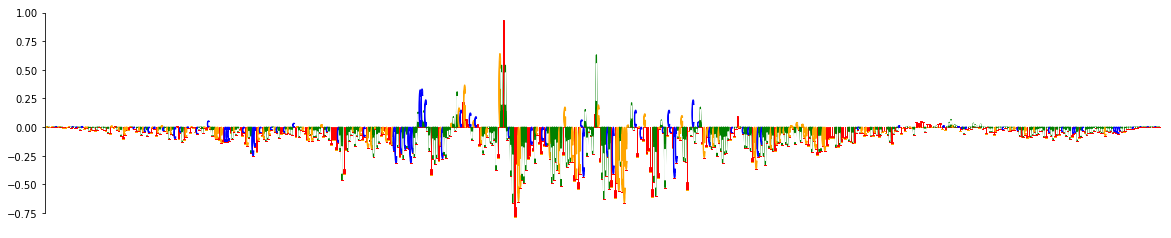

In [14]:
gp.plot(0)

Displaying 600bp in a seqlogo is not very useful, hence zooming is possible by genomic coordinates (`limit_region_genomic`) or by subsetting the _grad*input_ array directly using the `limit_region` parameter:

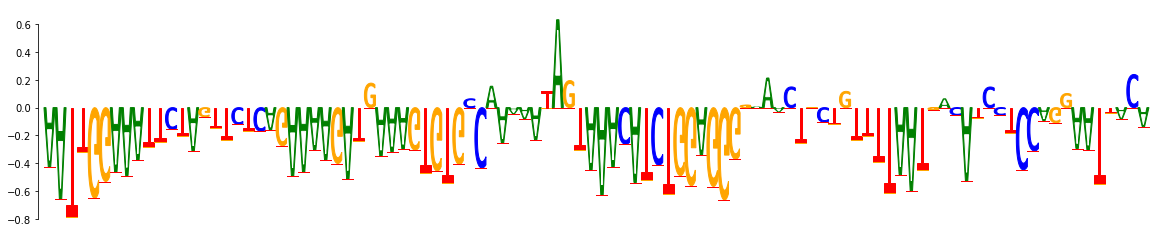

In [13]:
# subset model input sequence to bases 250 to 350 for plotting
gp.plot(0, limit_region=(250,350))

# CLI 
Using the equivalent command in the CLI the same plot can be produced.
Before we can do that we have to delete the file that we have just created a minute ago:

In [15]:
import os
if os.path.exists("example_data/Basset_grad_query_Basset_out.hdf5"):
    os.unlink("example_data/Basset_grad_query_Basset_out.hdf5")

In [16]:
! kipoi interpret grad Basset --source kipoi --dataloader_args '{"fasta_file": \
   "example_data/hg19_chr22.fa", "intervals_file": "example_data/Basset_grad_query_Basset.bed"}'\
   --layer "21.1" --filter_idx 120 --output "example_data/Basset_grad_query_Basset_out.hdf5"

INFO [kipoi.sources] Update /nfs/research1/stegle/users/rkreuzhu/.kipoi/models/
Already up-to-date.
INFO [kipoi.sources] git-lfs pull -I Basset/**
INFO [kipoi.sources] model Basset loaded
INFO [kipoi.sources] git-lfs pull -I Basset/./**
INFO [kipoi.sources] dataloader Basset/. loaded
INFO [kipoi.data] successfully loaded the dataloader from /nfs/research1/stegle/users/rkreuzhu/.kipoi/models/Basset/dataloader.py::SeqDataset
INFO [kipoi.pipeline] dataloader.output_schema is compatible with model.schema
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


now we can visualise the plot identically in python:

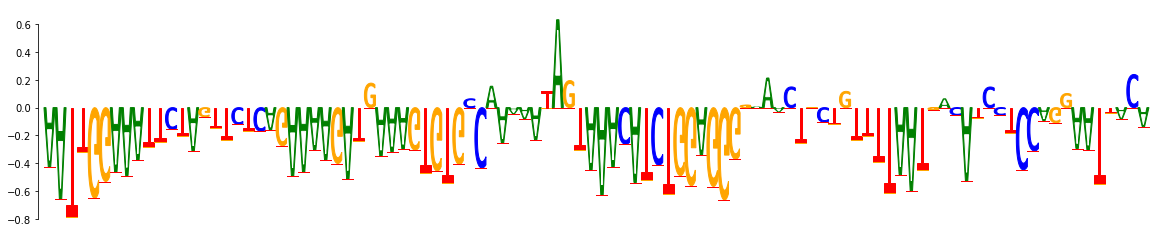

In [17]:
# generate the GradPlotter instance:
gp = GradPlotter.from_hdf5("example_data/Basset_grad_query_Basset_out.hdf5", "Basset")
gp.plot(0, limit_region=(250,350))

# Using FactorNet as an example

**_WARNING:_** You should restart the kernel at this point, because using a PyTorch model and loading a Keras model at the same time may cause the loading of the Keras model to hang!

FactorNet is a model to predict transcription factor binding that also uses open chromatin and mappability tracks as inputs. Here we will illustrate one of the strengths of using gradients to interpret model predictions.

Let's start with selecting a CTCF binding site and writing out the corresponding bed file:

In [1]:
with open("example_data/FactorNet_CTCF_grad_query.bed", "w") as ofh:
    chrom, center, intervals_len = "chr22", 28712021, 1002
    start = center - intervals_len//2
    end = center + intervals_len//2 + (intervals_len % 2)
    ofh.write("\t".join([chrom, str(start), str(end)]) + "\n")

Now let's load the model:

In [2]:
import kipoi
fn_model = kipoi.get_model('FactorNet/CTCF/meta_RNAseq_Unique35_DGF', source = "kipoi")

Using TensorFlow backend.
/nfs/research1/stegle/users/rkreuzhu/conda-envs/kipoi_interpret/lib/python3.6/site-packages/keras/engine/topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
fn_datalaoder_arguments = fn_model.default_dataloader.example_kwargs
# prepend the model path for all path entries in the dataloader arguments.
fn_datalaoder_arguments = {k:fn_model.source_dir + "/" + v if not k == 'cell_line' else v 
                           for k,v in fn_datalaoder_arguments.items()}
fn_datalaoder_arguments['intervals_file'] = "example_data/FactorNet_CTCF_grad_query.bed"

# Check if the arguments have been set correctly:
fn_datalaoder_arguments

{'intervals_file': 'example_data/FactorNet_CTCF_grad_query.bed',
 'fasta_file': '/nfs/research1/stegle/users/rkreuzhu/.kipoi/models/FactorNet/CTCF/meta_RNAseq_Unique35_DGF/example_files/hg38_chr22.fa',
 'dnase_file': '/nfs/research1/stegle/users/rkreuzhu/.kipoi/models/FactorNet/CTCF/meta_RNAseq_Unique35_DGF/example_files/dnase_synth.chr22.bw',
 'cell_line': 'PC-3'}

Now run the gradient calculation pipeline on the `merge3` layer of the model. The model has only one output, so we select that one.

In [4]:
grad_preds = fn_model.pipeline.input_grad(fn_datalaoder_arguments, layer ='merge_3', filter_idx = [0])

1it [00:06,  6.85s/it]


At the moment we don't support more complex visualisation for model inputs that are not of the `special_type` `DNASequence`. Therefore and since FactorNet's `seq` input is a 1002x6 input, which is not a one-hot encoded DNA-sequence, so we will have to manually write a small function for plotting:

In [5]:
def plot_fnet(input_arr, grad_arr):
    import seaborn as sns
    import matplotlib.pylab as plt
    from kipoi_veff.external.concise.seqplotting_deps import seqlogo
    plt.figure(figsize=(14,4))
    # calculate the grad*input values:
    values = (input_arr*grad_arr).T
    # get axes objects
    ax_s = plt.subplot(2,1,1)
    ax_h = plt.subplot(2,1,2)
    # make the plots
    seqlogo(values[:4,:].T, ax = ax_s)
    sns.heatmap(values[4:5,:], ax = ax_h, cbar=False)
    # plot formatting
    ax_s.get_xaxis().set_visible(False)
    sns.despine(trim = True, ax = ax_s, bottom = True)
    ax_h.get_xaxis().set_visible(False)
    ax_h.get_yaxis().set_visible(False)

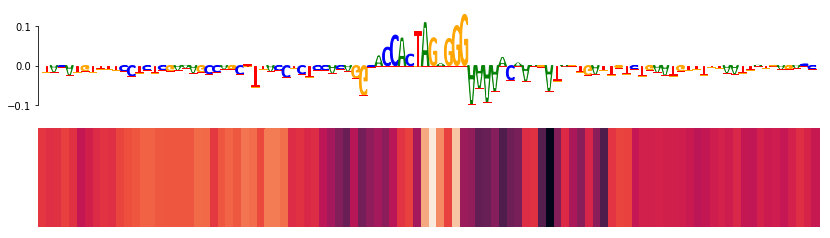

In [7]:
plot_fnet(grad_preds['inputs'][0][0,450:550,:], grad_preds['grads'][0][0,450:550,:])

FactorNet has a separate model input for the reverse-complement of the sequence, which is model input `1`. We can visualise it here:

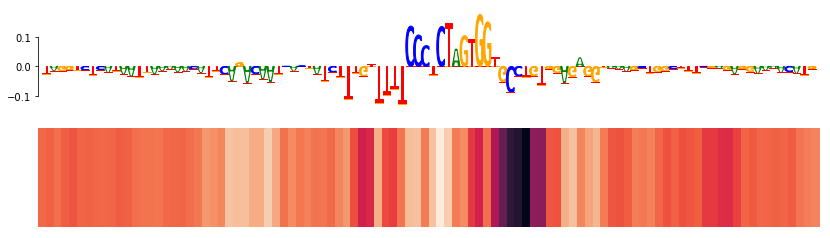

In [8]:
plot_fnet(grad_preds['inputs'][1][0,450:550,:], grad_preds['grads'][1][0,450:550,:])